# Task 7.6: Sourcing & Analyzing Time Series Data

## This script contains the following points:

### 1. Conduct time-series analysis in Python
### 2. Prepare time-series data for forecasting

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = '3ecC3DsaMQvNfsQzFmcu'

In [3]:
# Importing the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable.
# Data is refreshed quarterly
# It was last updated in July of 2021

data = quandl.get('FRED/GDPPOT')

In [4]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

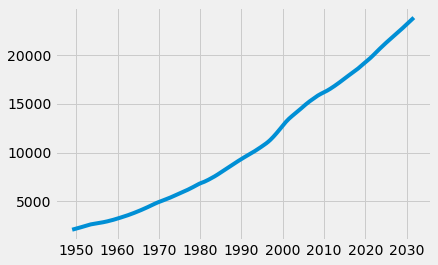

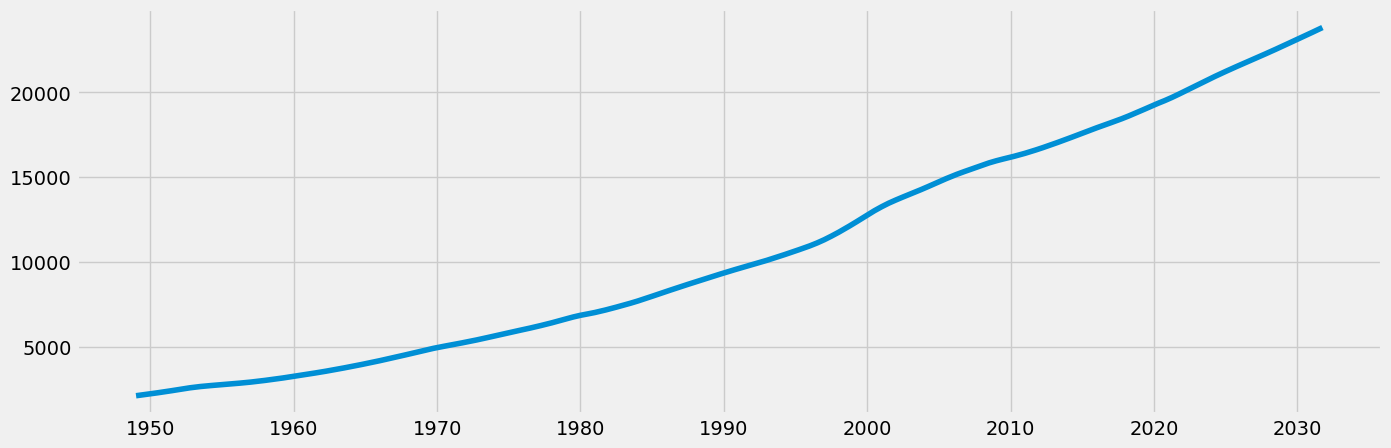

In [8]:
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## The graph shows a clear upward trend over the past 70 years, so its reasonable to assume the data will continue to show an upward trend.

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [11]:
# Filtering the dates so that there is no forecasted data interfering with the results
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2021-07-01')]

In [12]:
data_sub.shape

(166, 2)

In [13]:
data_sub.head()

,Date,Value
124,1980-01-01,6847.481683
125,1980-04-01,6890.146039
126,1980-07-01,6928.061362
127,1980-10-01,6968.010712
128,1981-01-01,7012.104757


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6847.481683
1980-04-01,6890.146039
1980-07-01,6928.061362
1980-10-01,6968.010712
1981-01-01,7012.104757


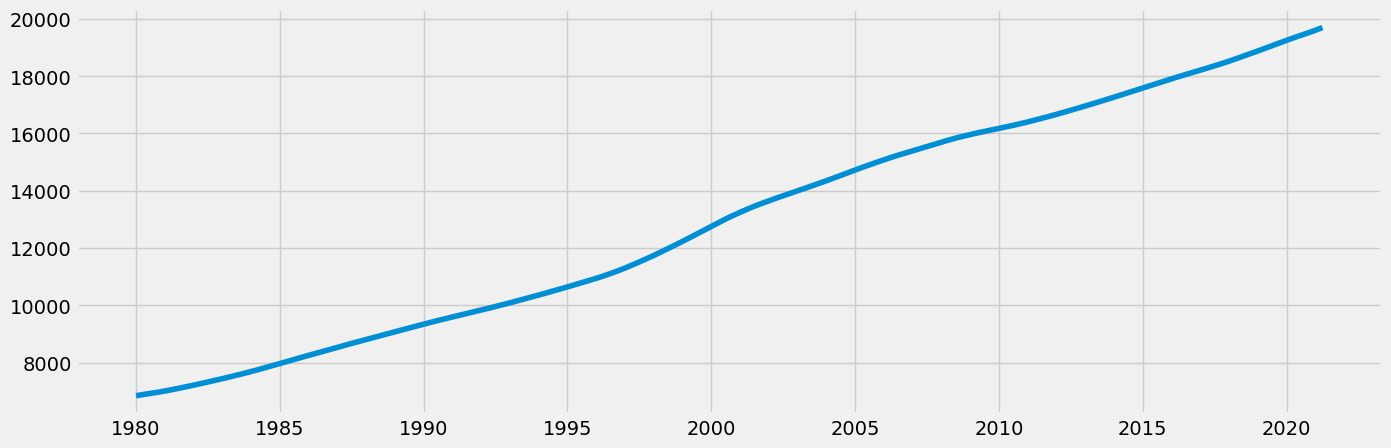

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## Even with the subset, the data is still showing a clear upward trend

In [16]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

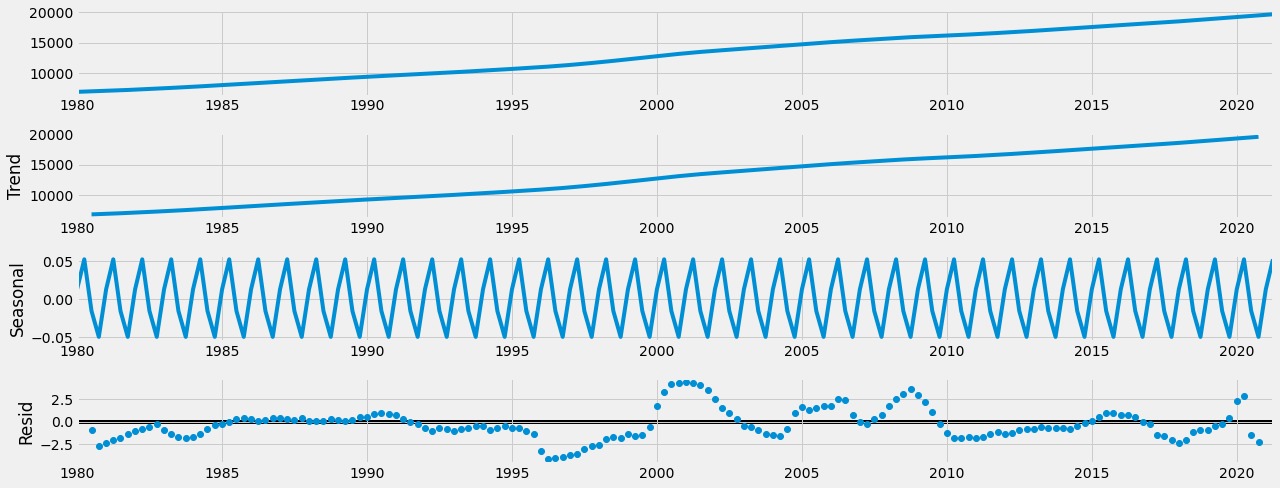

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.465088
p-value                          0.983772
Number of Lags Used              2.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


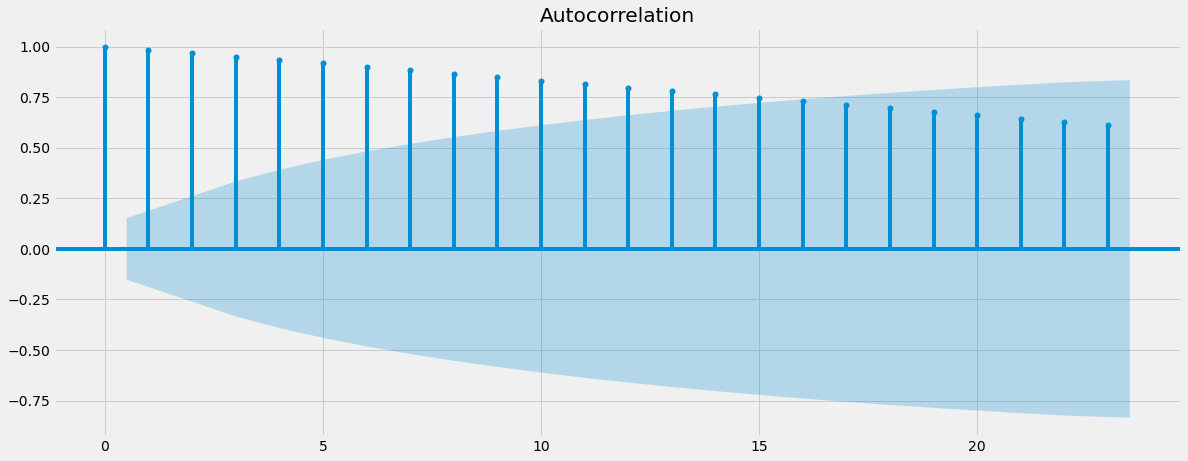

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## The P-Value here is over the threshold of .05, so a round of differencing is necessary. 

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Value
datetime,
1980-04-01,42.664356
1980-07-01,37.915323
1980-10-01,39.949350
1981-01-01,44.094045
1981-04-01,47.180044


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

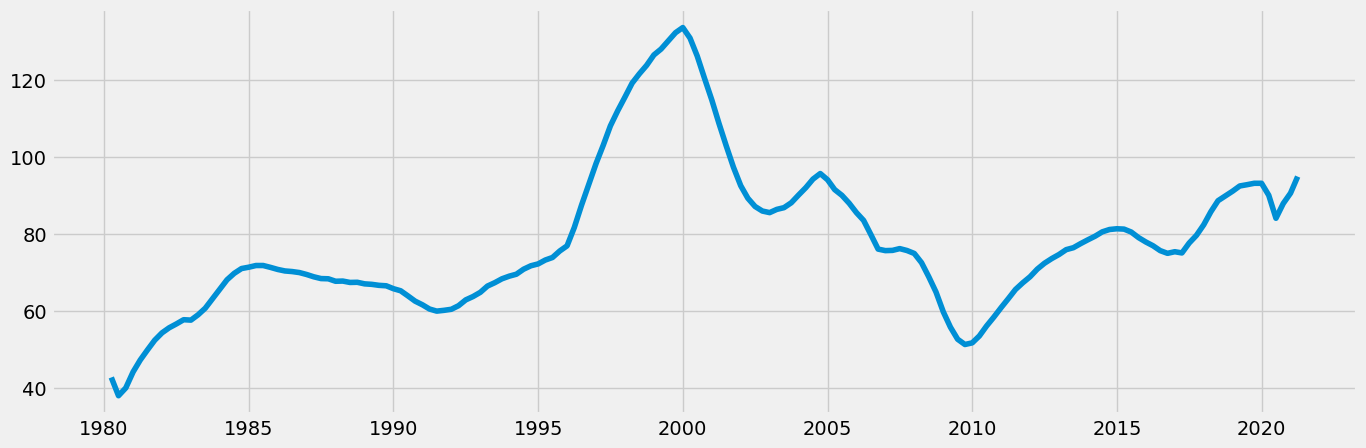

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

## The graph here shows much higher volatility and you can see where events like the economic crash of 2009 had an effect on the GDP

In [28]:
# re-run the Dickey-Fuller test to see if we are now within our certainty threshold.
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.430963
p-value                          0.009948
Number of Lags Used              1.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


## The P-value here is much lower now and our test statistic is lower than the critical values at 5% and 10%, meaning that we can say with a high level of certainty that there is not a root unit present in our data set

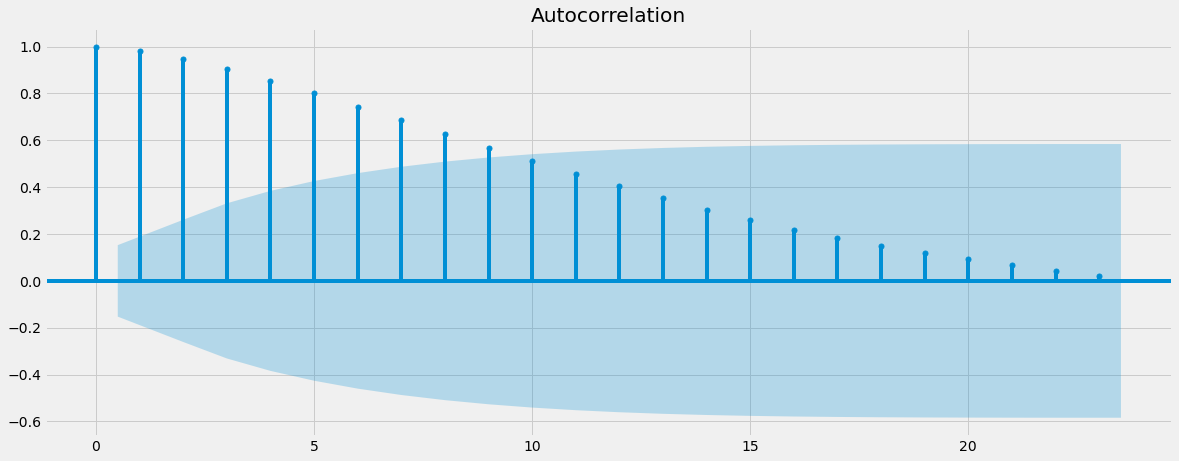

In [29]:
plot_acf(data_diff)
plt.show()